# CHRONOS: Foundation Model для прогнозирования временных рядов

В этом ноутбуке тестируем **CHRONOS** - предобученную foundation модель от Amazon для прогнозирования временных рядов с использованием walk-forward валидации.

## О CHRONOS:
**CHRONOS** - это семейство предобученных моделей, основанных на трансформерах, специально разработанных для прогнозирования временных рядов. Это первая successful попытка создать "foundation model" для временных рядов.

### Тестируемые варианты CHRONOS:
1. **chronos-t5-tiny** - компактная версия (8M параметров)
2. **chronos-t5-mini** - мини версия (20M параметров)  
3. **chronos-t5-small** - малая версия (46M параметров)
4. **chronos-t5-base** - базовая версия (200M параметров)
5. **chronos-t5-large** - большая версия (710M параметров)

## Ключевые особенности CHRONOS:
- **Zero-shot прогнозирование**: работает без дообучения на новых рядах
- **Предобученность**: обучена на большом корпусе временных рядов
- **Transformer архитектура**: использует T5 как backbone
- **Токенизация**: преобразует значения временного ряда в токены
- **Универсальность**: работает с любыми типами временных рядов

## Методология тестирования:
- **Walk-forward валидация**: строгая проверка на будущих данных
- **Разбивка данных**: 95% обучение, 5% тест
- **Горизонт прогноза**: 1 шаг вперед
- **Контекстное окно**: 30-50 последних точек

## Преимущества Foundation Model подхода:
- Обобщение на новые домены без дообучения
- Понимание сложных временных паттернов
- Высокое качество out-of-the-box
- Масштабируемость и эффективность


In [ ]:
!pip install virtualenv

In [ ]:
import virtualenv
import subprocess
import os
import sys

notebook_name = "chronos"
virtualenv.cli_run(["venvs/" + notebook_name, "--no-download"])

venv_dir = "venvs/" + notebook_name
python_path = os.path.join(venv_dir, "bin", "python")
display_name = "Python (" + notebook_name + ")"
kernel_name = notebook_name

# Установка ipykernel в venv
subprocess.check_call([os.path.join(venv_dir, "bin", "pip"), "install", "ipykernel"])

# Регистрация ядра
subprocess.check_call([
    python_path, "-m", "ipykernel", "install",
    "--user",
    "--name", kernel_name,
    "--display-name", display_name
])

In [ ]:
import sys
print(sys.executable)

In [ ]:
import subprocess
import os
import sys

# Путь к pip в активном ядре
pip_path = os.path.join(sys.prefix, "bin", "pip")

# Установка
subprocess.check_call([pip_path, "install", "chronos-forecasting", "torch", "matplotlib", "scikit-learn", "pandas", "numpy", "seaborn", "datasets"])

In [4]:
import warnings
warnings.filterwarnings('ignore')

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import time
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from chronos import ChronosPipeline

# Настройка визуализации
plt.style.use('default')
sns.set_palette("husl")
pd.options.display.float_format = '{:.4f}'.format

# Проверка доступности CUDA
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Используемое устройство: {device}")
print(f"CUDA доступна: {torch.cuda.is_available()}")

if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Памяти GPU: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

print("Библиотеки загружены успешно!")

Используемое устройство: cpu
CUDA доступна: False
Библиотеки загружены успешно!


In [5]:
def directional_accuracy(actual, predicted):
    """
    Calculates Directional Accuracy by comparing each predicted value's
    direction with the actual value's direction.
    """
    if len(actual) < 2 or len(predicted) < 2:
        return np.nan
    
    actual_direction = np.sign(actual[1:] - actual[:-1])  # Direction of actual values
    predicted_direction = np.sign(predicted[1:] - predicted[:-1])  # Direction of predictions

    # Calculate accuracy
    return np.mean(actual_direction == predicted_direction) * 100

def rmse_score(y_true, y_pred):
    """Корень среднеквадратичной ошибки"""
    return np.sqrt(mean_squared_error(y_true, y_pred))

print("Функции для расчета метрик определены!")

Функции для расчета метрик определены!


Загружен AFLT: 2375 точек
Загружен LKOH: 2375 точек
Загружен MOEX: 2375 точек
Загружен NVTK: 2373 точек
Загружен PIKK: 2375 точек
Загружен SBER: 2375 точек
Загружен VKCO: 1197 точек
Загружен VTBR: 1722 точек
Загружен X5: 1499 точек
Загружен YDEX: 2339 точек
\nЗагружено временных рядов: 10
\nИспользуем ряд: AFLT
Период: 2016-01-01 00:00:00+00:00 - 2025-04-30 00:00:00+00:00
Количество точек: 2375
\nСтатистика ряда:
count   2375.0000
mean      85.2747
std       45.6730
min       22.4400
25%       51.8700
50%       72.6800
75%      107.1500
max      225.0000
Name: close, dtype: float64


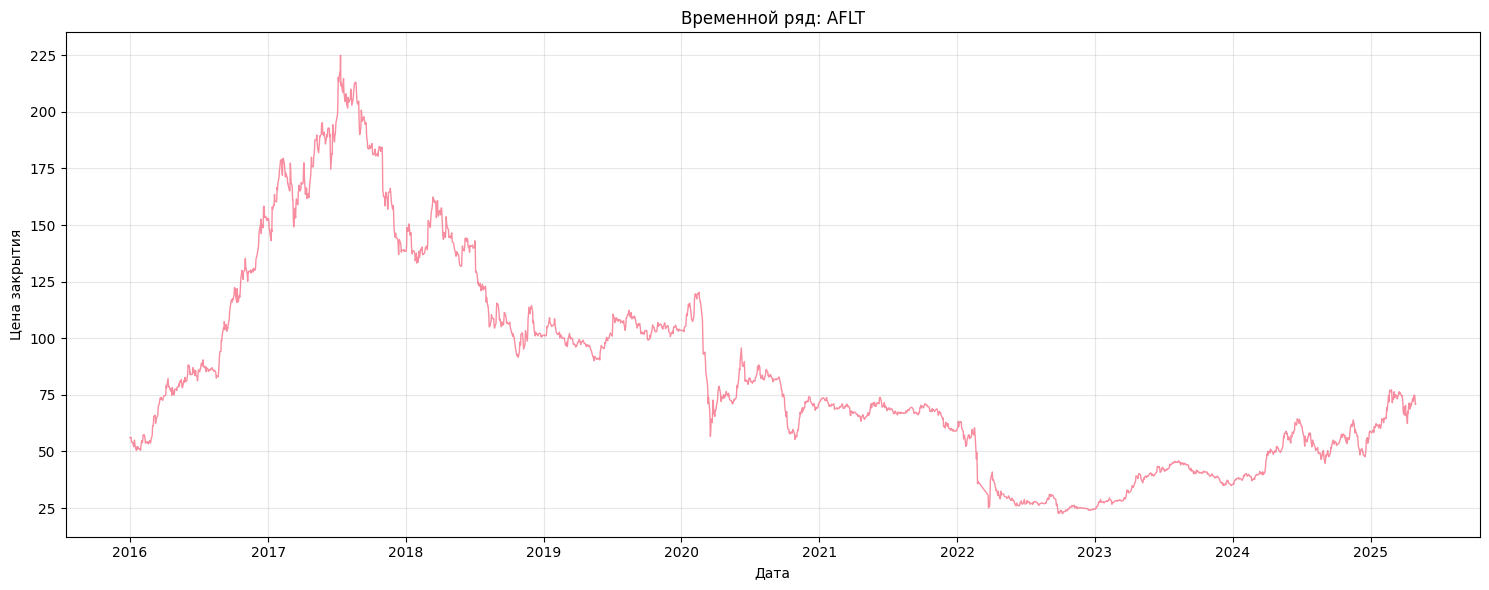

In [6]:
def load_data(data_path="../../data/series/"):
    """Загрузка временных рядов из CSV файлов"""
    data_dict = {}
    data_path = Path(data_path)
    
    if not data_path.exists():
        print(f"Папка {data_path} не найдена!")
        return data_dict
    
    for csv_file in data_path.glob("*.csv"):
        try:
            df = pd.read_csv(csv_file)
            if 'timestamp' in df.columns and 'close' in df.columns:
                df['timestamp'] = pd.to_datetime(df['timestamp'])
                df = df.set_index('timestamp').sort_index()
                symbol = csv_file.stem
                data_dict[symbol] = df[['close']]
                print(f"Загружен {symbol}: {len(df)} точек")
            else:
                print(f"Пропущен {csv_file.name}: нет колонок 'timestamp' или 'close'")
        except Exception as e:
            print(f"Ошибка загрузки {csv_file.name}: {e}")
    
    return data_dict

# Загрузка данных
data = load_data()
print(f"\\nЗагружено временных рядов: {len(data)}")

if len(data) > 0:
    # Выберем первый доступный ряд для демонстрации
    symbol = list(data.keys())[0]
    df = data[symbol]
    print(f"\\nИспользуем ряд: {symbol}")
    print(f"Период: {df.index[0]} - {df.index[-1]}")
    print(f"Количество точек: {len(df)}")
    
    # Покажем статистику
    print("\\nСтатистика ряда:")
    print(df['close'].describe())
    
    # Визуализация временного ряда
    plt.figure(figsize=(15, 6))
    plt.plot(df.index, df['close'], linewidth=1, alpha=0.8)
    plt.title(f'Временной ряд: {symbol}')
    plt.xlabel('Дата')
    plt.ylabel('Цена закрытия')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
else:
    print("Данные не найдены. Используем синтетический ряд.")
    # Создадим синтетический ряд для демонстрации
    dates = pd.date_range('2020-01-01', periods=200, freq='D')
    np.random.seed(42)
    prices = 100 + np.cumsum(np.random.randn(200) * 0.02)
    df = pd.DataFrame({'close': prices}, index=dates)
    symbol = 'SYNTHETIC'
    print(f"Создан синтетический ряд: {len(df)} точек")

In [19]:
# Конфигурация CHRONOS моделей
CHRONOS_MODELS = {
    'chronos-t5-tiny': {
        'model_name': 'amazon/chronos-t5-tiny',
        'description': 'Самая компактная версия (8M параметров)',
        'context_length': 64,
        'memory_gb': 0.5
    },
    'chronos-t5-mini': {
        'model_name': 'amazon/chronos-t5-mini', 
        'description': 'Мини версия (20M параметров)',
        'context_length': 64,
        'memory_gb': 1.0
    },
    'chronos-t5-small': {
        'model_name': 'amazon/chronos-t5-small',
        'description': 'Малая версия (46M параметров)',
        'context_length': 64,
        'memory_gb': 2.0
    },
    'chronos-t5-base': {
        'model_name': 'amazon/chronos-t5-base',
        'description': 'Базовая версия (200M параметров)',
        'context_length': 64,
        'memory_gb': 3.0
    },
    'chronos-t5-large': {
        'model_name': 'amazon/chronos-t5-large',
        'description': 'Большая версия (710M параметров)',
        'context_length': 64,
        'memory_gb': 6.0
    }
}

print("Доступные CHRONOS модели:")
for model_name, config in CHRONOS_MODELS.items():
    print(f"     {model_name}: {config['description']}")
    print(f"     Контекст: {config['context_length']}, Память: ~{config['memory_gb']} GB")

# Выбираем модели для тестирования в зависимости от доступной памяти
if torch.cuda.is_available():
    gpu_memory_gb = torch.cuda.get_device_properties(0).total_memory / 1e9
    print(f"\\nДоступно памяти GPU: {gpu_memory_gb:.1f} GB")
    
    # Фильтруем модели по доступной памяти
    selected_models = {k: v for k, v in CHRONOS_MODELS.items() 
                      if v['memory_gb'] <= gpu_memory_gb * 0.8}  # 80% от доступной памяти
else:
    print(f"\nGPU недоступно, используем CPU (только tiny и mini)")
    # На CPU используем только легкие модели
    selected_models = {k: v for k, v in CHRONOS_MODELS.items() 
                      if k in ['chronos-t5-tiny', 'chronos-t5-mini']}

selected_models = CHRONOS_MODELS

print(f"\nВыбранные модели для тестирования: {list(selected_models.keys())}")

Доступные CHRONOS модели:
     chronos-t5-tiny: Самая компактная версия (8M параметров)
     Контекст: 64, Память: ~0.5 GB
     chronos-t5-mini: Мини версия (20M параметров)
     Контекст: 64, Память: ~1.0 GB
     chronos-t5-small: Малая версия (46M параметров)
     Контекст: 64, Память: ~2.0 GB
     chronos-t5-base: Базовая версия (200M параметров)
     Контекст: 64, Память: ~3.0 GB
     chronos-t5-large: Большая версия (710M параметров)
     Контекст: 64, Память: ~6.0 GB

GPU недоступно, используем CPU (только tiny и mini)

Выбранные модели для тестирования: ['chronos-t5-tiny', 'chronos-t5-mini', 'chronos-t5-small', 'chronos-t5-base', 'chronos-t5-large']


In [28]:
def walk_forward_validation_chronos(model_name, series, window_size=50):
    """
    Walk-forward валидация для CHRONOS модели
    
    Args:
        model_name (str): Название CHRONOS модели
        series (pd.Series): Временной ряд для прогнозирования
        window_size (int): Размер контекстного окна
    
    Returns:
        dict: Результаты с предсказаниями и метриками
    """
    
    print(f"\nЗагрузка модели {model_name}...")
    start_load = time.time()
    
    try:
        # Загружаем CHRONOS pipeline
        pipeline = ChronosPipeline.from_pretrained(
            model_name,
            device_map=device,
            torch_dtype=torch.bfloat16 if device.type == 'cuda' else torch.float32,
        )
        
        load_time = time.time() - start_load
        print(f"Модель загружена за {load_time:.1f} секунд")
        
    except Exception as e:
        print(f"Ошибка загрузки модели {model_name}: {e}")
        return {'error': str(e)}
    
    # Инициализация результатов
    results = {
        'true_values': [],
        'predictions': [],
        'step_times': [],
        'model_name': model_name,
        'window_size': window_size,
        'load_time': load_time
    }
    
    # Разбивка данных: 95% для обучения, 5% для тестирования
    split_point = int(len(series) * 0.95)
    test_start = max(split_point, window_size)
    
    print(f"\nНастройки валидации:")
    print(f"   Обучающих точек: {split_point}")
    print(f"   Тестовых точек: {len(series) - test_start}")
    print(f"   Размер окна: {window_size}")
    
    # Walk-forward валидация
    for step, i in enumerate(range(test_start, len(series))):
        step_start = time.time()
        
        # Подготовка контекста (последние window_size точек)
        context = series.iloc[i-window_size:i].values.astype(np.float32)
        true_value = series.iloc[i]
        
        try:
            # Получаем прогноз от CHRONOS
            # context должен быть в виде тензора
            context_tensor = torch.tensor(context).unsqueeze(0)  # Add batch dimension
            
            # Прогноз на 1 шаг вперед
            forecast = pipeline.predict(
                context=context_tensor,
                prediction_length=1,
                num_samples=1,
                temperature=0.2
            )
            
            # Извлекаем значение прогноза
            pred_value = float(forecast[0, 0, 0])  # [batch, sample, step]
            
            step_time = time.time() - step_start
            
            # Сохраняем результаты
            results['true_values'].append(true_value)
            results['predictions'].append(pred_value)
            results['step_times'].append(step_time)
            
            if (step + 1) % 5 == 0 or (step + 1) == len(series) - test_start:
                print(f"   Шаг {step+1:3d}/{len(series)-test_start}: "
                      f"True={true_value:8.2f}, Pred={pred_value:8.2f}, "
                      f"Time={step_time:.2f}s")
                
        except Exception as e:
            print(f"Ошибка на шаге {step+1}: {e}")
            results['true_values'].append(true_value)
            results['predictions'].append(np.nan)
            results['step_times'].append(time.time() - step_start)
    
    # Вычисление финальных метрик
    try:
        true_vals = np.array(results['true_values'])
        pred_vals = np.array(results['predictions'])
        
        # Убираем NaN значения
        valid_mask = ~np.isnan(pred_vals)
        if np.sum(valid_mask) > 0:
            true_valid = true_vals[valid_mask]
            pred_valid = pred_vals[valid_mask]
            
            results['metrics'] = {
                'MAE': mean_absolute_error(true_valid, pred_valid),
                'MAPE': mean_absolute_percentage_error(true_valid, pred_valid) * 100,
                'RMSE': rmse_score(true_valid, pred_valid),
                'DA': directional_accuracy(true_valid, pred_valid),
                'Valid_Predictions': np.sum(valid_mask),
                'Total_Predictions': len(pred_vals),
                'Success_Rate': np.sum(valid_mask) / len(pred_vals) * 100,
                'Avg_Time': np.mean(results['step_times']),
                'Total_Time': np.sum(results['step_times'])
            }
        else:
            results['metrics'] = {'error': 'Нет валидных предсказаний'}
            
    except Exception as e:
        results['metrics'] = {'error': f'Ошибка расчета метрик: {e}'}
    
    # Очистка памяти
    del pipeline
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    
    return results

print("Функция walk-forward валидации для CHRONOS определена!")

Функция walk-forward валидации для CHRONOS определена!


In [21]:
# Основной пайплайн тестирования CHRONOS моделей
print("ЗАПУСК ТЕСТИРОВАНИЯ CHRONOS МОДЕЛЕЙ")
print("=" * 60)

# Временной ряд для тестирования
series = df['close']
print(f"\\nТестируемый ряд: {symbol}")
print(f"Длина ряда: {len(series)} точек")

# Хранилище результатов
all_results = {}
all_metrics = {}

# Определяем оптимальный размер окна
optimal_window = min(50, len(series) // 4)  # Не более 25% от данных
print(f"Размер контекстного окна: {optimal_window}")

# Тестирование каждой модели
for model_key, model_config in selected_models.items():
    model_name = model_config['model_name']
    
    print(f"\\n" + "="*60)
    print(f"ТЕСТИРОВАНИЕ: {model_key}")
    print(f"Описание: {model_config['description']}")
    print(f"Model ID: {model_name}")
    print(f"Требуемая память: ~{model_config['memory_gb']} GB")
    print("-" * 60)
    
    # Запуск валидации
    start_time = time.time()
    
    try:
        results = walk_forward_validation_chronos(
            model_name=model_name,
            series=series,
            window_size=optimal_window
        )
        
        total_time = time.time() - start_time
        
        # Проверяем на ошибки
        if 'error' in results:
            print(f"\n{model_key} завершился с ошибкой: {results['error']}")
            all_metrics[model_key] = {'error': results['error']}
        else:
            # Сохраняем результаты
            all_results[model_key] = results
            
            if 'error' not in results['metrics']:
                all_metrics[model_key] = results['metrics']
                metrics = results['metrics']
                
                print(f"\n{model_key} успешно завершен!")
                print(f"Результаты:")
                print(f"   MAE: {metrics['MAE']:.4f}")
                print(f"   MAPE: {metrics['MAPE']:.2f}%")
                print(f"   RMSE: {metrics['RMSE']:.4f}")
                print(f"   DA: {metrics['DA']:.2f}%")
                print(f"   Среднее время: {metrics['Avg_Time']:.3f}с")
                print(f"   Успешность: {metrics['Success_Rate']:.1f}%")
                print(f"   Общее время: {total_time:.1f}с")
            else:
                print(f"\\nОшибка расчета метрик для {model_key}: {results['metrics']['error']}")
                all_metrics[model_key] = results['metrics']
        
    except Exception as e:
        print(f"\\nКритическая ошибка при тестировании {model_key}: {e}")
        all_metrics[model_key] = {'error': str(e)}
    
    # Принудительная очистка памяти между моделями
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        
    print(f"\\nПамять очищена после {model_key}")

print(f"\\n" + "="*60)
print("ВСЕ CHRONOS МОДЕЛИ ПРОТЕСТИРОВАНЫ!")
print("="*60)


ЗАПУСК ТЕСТИРОВАНИЯ CHRONOS МОДЕЛЕЙ
\nТестируемый ряд: AFLT
Длина ряда: 2375 точек
Размер контекстного окна: 50
\n============================================================
ТЕСТИРОВАНИЕ: chronos-t5-tiny
Описание: Самая компактная версия (8M параметров)
Model ID: amazon/chronos-t5-tiny
Требуемая память: ~0.5 GB
------------------------------------------------------------

Загрузка модели amazon/chronos-t5-tiny...
Модель загружена за 0.9 секунд

Настройки валидации:
   Обучающих точек: 2256
   Тестовых точек: 119
   Размер окна: 50
   Шаг   5/119: True=   48.52, Pred=   48.66, Time=0.01s
   Шаг  10/119: True=   49.97, Pred=   51.20, Time=0.01s
   Шаг  15/119: True=   49.30, Pred=   47.52, Time=0.01s
   Шаг  20/119: True=   54.86, Pred=   54.18, Time=0.01s
   Шаг  25/119: True=   58.13, Pred=   58.98, Time=0.01s
   Шаг  30/119: True=   60.50, Pred=   60.96, Time=0.01s
   Шаг  35/119: True=   61.45, Pred=   62.52, Time=0.01s
   Шаг  40/119: True=   60.15, Pred=   62.25, Time=0.01s
   Шаг

In [14]:
# Создание сводной таблицы результатов
print("\\nСВОДНАЯ ТАБЛИЦА РЕЗУЛЬТАТОВ CHRONOS МОДЕЛЕЙ")
print("=" * 80)

# Подготовка данных для таблицы
metrics_data = []
for model_name, metrics in all_metrics.items():
    if 'error' not in metrics:
        metrics_data.append({
            'Модель': model_name,
            'MAE': f"{metrics['MAE']:.4f}",
            'MAPE (%)': f"{metrics['MAPE']:.2f}",
            'RMSE': f"{metrics['RMSE']:.4f}",
            'DA (%)': f"{metrics['DA']:.2f}",
            'Среднее время (мс)': f"{metrics['Avg_Time']*1000:.1f}",
            'Успешность (%)': f"{metrics['Success_Rate']:.1f}",
            'Предсказаний': f"{metrics['Valid_Predictions']}/{metrics['Total_Predictions']}"
        })
    else:
        metrics_data.append({
            'Модель': model_name,
            'MAE': 'ERROR',
            'MAPE (%)': 'ERROR',
            'RMSE': 'ERROR',
            'DA (%)': 'ERROR',
            'Среднее время (мс)': 'ERROR',
            'Успешность (%)': 'ERROR',
            'Предсказаний': 'ERROR'
        })

# Создаем и отображаем таблицу
if metrics_data:
    results_df = pd.DataFrame(metrics_data)
    print(results_df.to_string(index=False))
    
    # Анализ лучших результатов
    valid_metrics = {k: v for k, v in all_metrics.items() if 'error' not in v}
    
    if valid_metrics:
        print("\\n\\nЛУЧШИЕ РЕЗУЛЬТАТЫ ПО МЕТРИКАМ:")
        print("-" * 50)
        
        # MAE (меньше - лучше)
        best_mae = min(valid_metrics.items(), key=lambda x: x[1]['MAE'])
        print(f"Лучший MAE: {best_mae[0]} ({best_mae[1]['MAE']:.4f})")
        
        # MAPE (меньше - лучше)
        best_mape = min(valid_metrics.items(), key=lambda x: x[1]['MAPE'])
        print(f"Лучший MAPE: {best_mape[0]} ({best_mape[1]['MAPE']:.2f}%)")
        
        # DA (больше - лучше)
        best_da = max(valid_metrics.items(), key=lambda x: x[1]['DA'])
        print(f"Лучший DA: {best_da[0]} ({best_da[1]['DA']:.2f}%)")
        
        # Скорость (меньше - лучше)
        best_speed = min(valid_metrics.items(), key=lambda x: x[1]['Avg_Time'])
        print(f"⚡ Самый быстрый: {best_speed[0]} ({best_speed[1]['Avg_Time']*1000:.1f}мс)")
        
        # Надежность (больше - лучше)
        best_reliability = max(valid_metrics.items(), key=lambda x: x[1]['Success_Rate'])
        print(f"Самый надежный: {best_reliability[0]} ({best_reliability[1]['Success_Rate']:.1f}%)")
        
        print("\\nРЕКОМЕНДАЦИИ:")
        print("-" * 30)
        
        # Общая рекомендация
        best_overall = min(valid_metrics.items(), key=lambda x: x[1]['MAE'])
        print(f"Лучшая модель по точности: {best_overall[0]}")
        
        # Рекомендация по скорости
        if len(valid_metrics) > 1:
            fast_models = sorted(valid_metrics.items(), key=lambda x: x[1]['Avg_Time'])[:2]
            print(f"Для продакшена (скорость): {fast_models[0][0]}")
            
        # Рекомендация по качеству
        quality_models = sorted(valid_metrics.items(), key=lambda x: x[1]['MAE'])[:2]
        print(f"Для максимальной точности: {quality_models[0][0]}")
        
    else:
        print("\\nНет успешных результатов для анализа")
        print("\\nРЕКОМЕНДАЦИИ ПО УСТРАНЕНИЮ ПРОБЛЕМ:")
        print("   • Проверьте доступность GPU памяти")
        print("   • Попробуйте уменьшить размер модели")
        print("   • Убедитесь в корректности установки chronos-forecasting")
        
else:
    print("Нет данных для отображения")


\nСВОДНАЯ ТАБЛИЦА РЕЗУЛЬТАТОВ CHRONOS МОДЕЛЕЙ
         Модель    MAE MAPE (%)   RMSE DA (%) Среднее время (мс) Успешность (%) Предсказаний
chronos-t5-tiny 1.6904     0.03 2.2433  43.22               14.0          100.0      119/119
chronos-t5-mini 1.7837     0.03 2.2698  52.54               17.8          100.0      119/119
\n\nЛУЧШИЕ РЕЗУЛЬТАТЫ ПО МЕТРИКАМ:
--------------------------------------------------
Лучший MAE: chronos-t5-tiny (1.6904)
Лучший MAPE: chronos-t5-tiny (0.03%)
Лучший DA: chronos-t5-mini (52.54%)
⚡ Самый быстрый: chronos-t5-tiny (14.0мс)
Самый надежный: chronos-t5-tiny (100.0%)
\nРЕКОМЕНДАЦИИ:
------------------------------
Лучшая модель по точности: chronos-t5-tiny
Для продакшена (скорость): chronos-t5-tiny
Для максимальной точности: chronos-t5-tiny


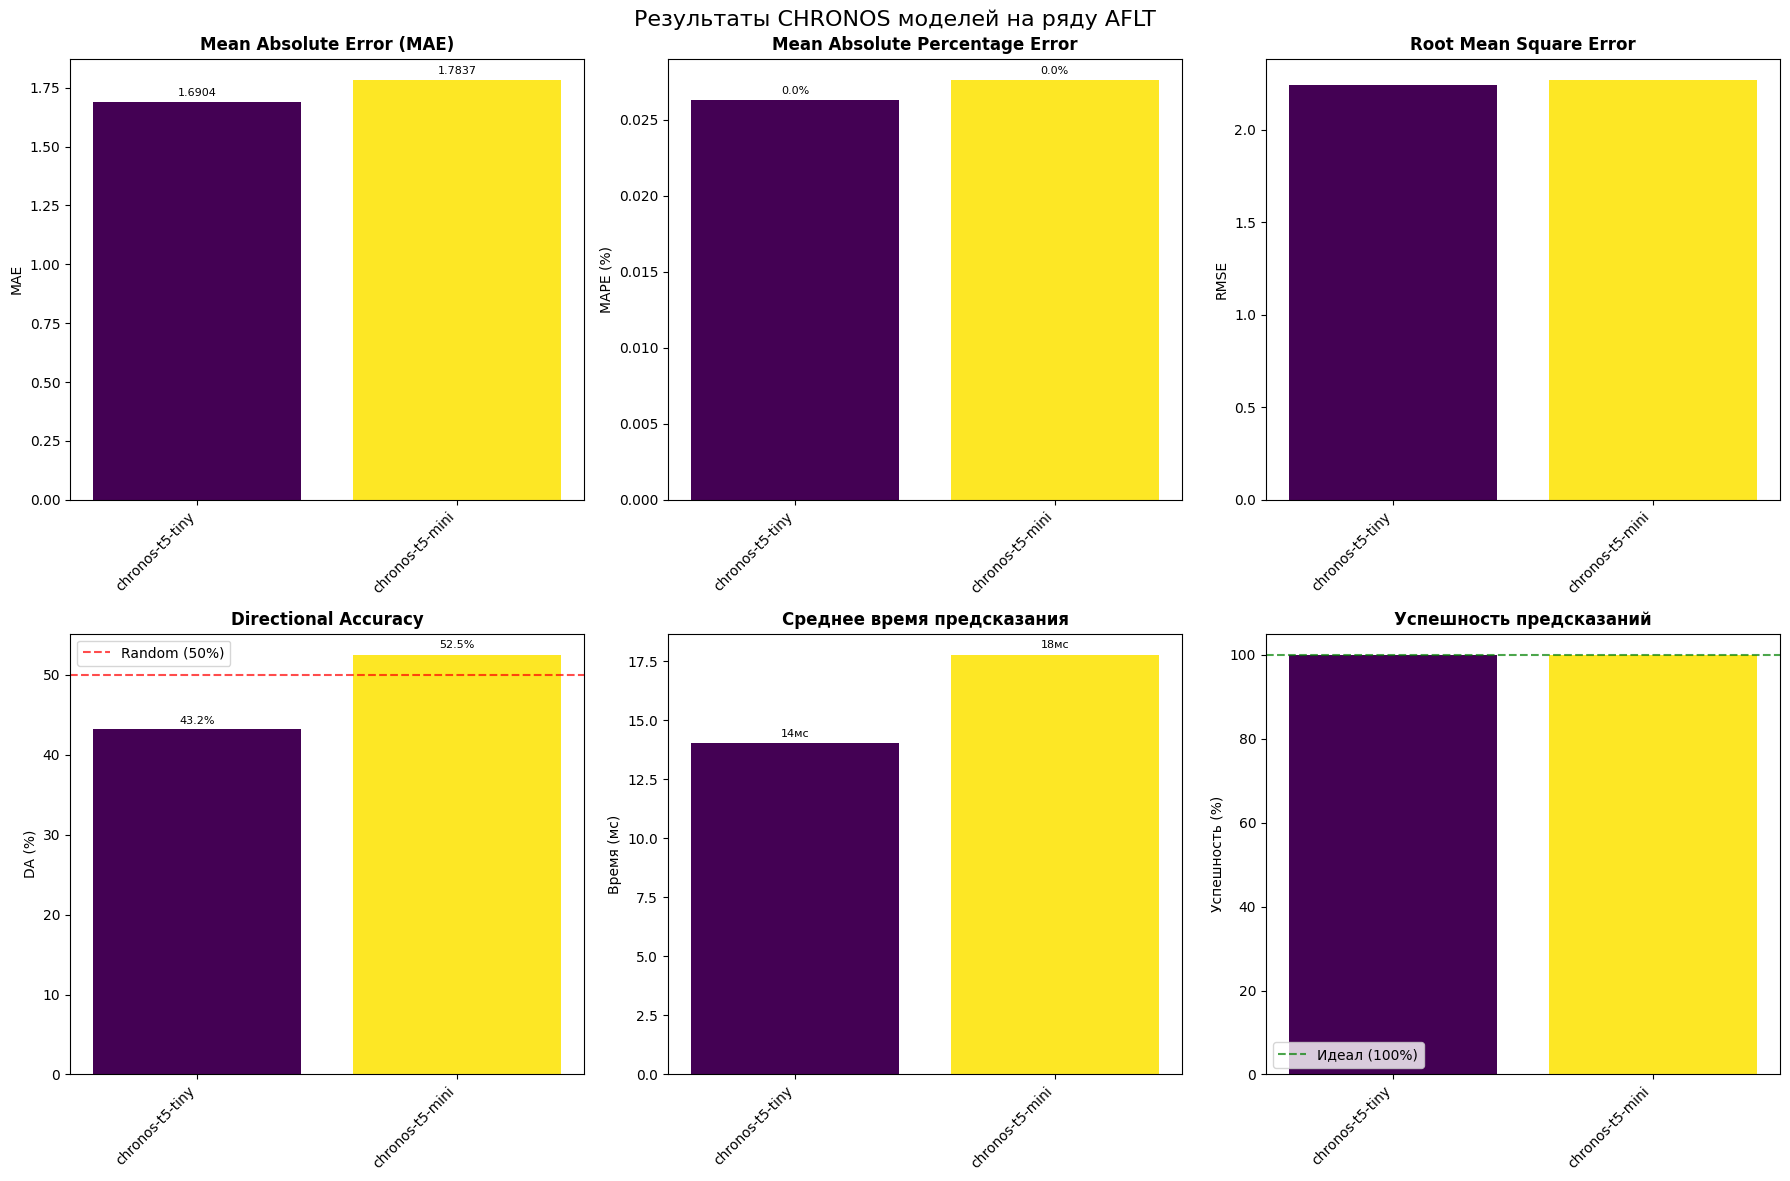

\n📈 Основные графики отображены!


In [15]:
# Визуализация результатов CHRONOS моделей
valid_metrics = {k: v for k, v in all_metrics.items() if 'error' not in v}

if valid_metrics and len(valid_metrics) > 0:
    # Основная визуализация метрик
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle(f'Результаты CHRONOS моделей на ряду {symbol}', fontsize=16, y=0.98)
    
    model_names = list(valid_metrics.keys())
    n_models = len(model_names)
    
    # Подготовка данных
    mae_values = [valid_metrics[m]['MAE'] for m in model_names]
    mape_values = [valid_metrics[m]['MAPE'] for m in model_names]
    rmse_values = [valid_metrics[m]['RMSE'] for m in model_names]
    da_values = [valid_metrics[m]['DA'] for m in model_names]
    time_values = [valid_metrics[m]['Avg_Time'] * 1000 for m in model_names]  # в миллисекундах
    success_values = [valid_metrics[m]['Success_Rate'] for m in model_names]
    
    # Цветовая палитра для CHRONOS моделей
    colors = plt.cm.viridis(np.linspace(0, 1, n_models))
    
    # 1. MAE
    bars1 = axes[0,0].bar(range(n_models), mae_values, color=colors)
    axes[0,0].set_title('Mean Absolute Error (MAE)', fontweight='bold')
    axes[0,0].set_ylabel('MAE')
    axes[0,0].set_xticks(range(n_models))
    axes[0,0].set_xticklabels(model_names, rotation=45, ha='right')
    
    # Добавляем значения на столбцы
    for i, (bar, val) in enumerate(zip(bars1, mae_values)):
        height = bar.get_height()
        axes[0,0].text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                      f'{val:.4f}', ha='center', va='bottom', fontsize=8)
    
    # 2. MAPE
    bars2 = axes[0,1].bar(range(n_models), mape_values, color=colors)
    axes[0,1].set_title('Mean Absolute Percentage Error', fontweight='bold')
    axes[0,1].set_ylabel('MAPE (%)')
    axes[0,1].set_xticks(range(n_models))
    axes[0,1].set_xticklabels(model_names, rotation=45, ha='right')
    
    for i, (bar, val) in enumerate(zip(bars2, mape_values)):
        height = bar.get_height()
        axes[0,1].text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                      f'{val:.1f}%', ha='center', va='bottom', fontsize=8)
    
    # 3. RMSE
    bars3 = axes[0,2].bar(range(n_models), rmse_values, color=colors)
    axes[0,2].set_title('Root Mean Square Error', fontweight='bold')
    axes[0,2].set_ylabel('RMSE')
    axes[0,2].set_xticks(range(n_models))
    axes[0,2].set_xticklabels(model_names, rotation=45, ha='right')
    
    # 4. Directional Accuracy
    bars4 = axes[1,0].bar(range(n_models), da_values, color=colors)
    axes[1,0].set_title('Directional Accuracy', fontweight='bold')
    axes[1,0].set_ylabel('DA (%)')
    axes[1,0].set_xticks(range(n_models))
    axes[1,0].set_xticklabels(model_names, rotation=45, ha='right')
    axes[1,0].axhline(y=50, color='red', linestyle='--', alpha=0.7, label='Random (50%)')
    axes[1,0].legend()
    
    for i, (bar, val) in enumerate(zip(bars4, da_values)):
        height = bar.get_height()
        axes[1,0].text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                      f'{val:.1f}%', ha='center', va='bottom', fontsize=8)
    
    # 5. Время выполнения
    bars5 = axes[1,1].bar(range(n_models), time_values, color=colors)
    axes[1,1].set_title('Среднее время предсказания', fontweight='bold')
    axes[1,1].set_ylabel('Время (мс)')
    axes[1,1].set_xticks(range(n_models))
    axes[1,1].set_xticklabels(model_names, rotation=45, ha='right')
    
    for i, (bar, val) in enumerate(zip(bars5, time_values)):
        height = bar.get_height()
        axes[1,1].text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                      f'{val:.0f}мс', ha='center', va='bottom', fontsize=8)
    
    # 6. Успешность
    bars6 = axes[1,2].bar(range(n_models), success_values, color=colors)
    axes[1,2].set_title('Успешность предсказаний', fontweight='bold')
    axes[1,2].set_ylabel('Успешность (%)')
    axes[1,2].set_xticks(range(n_models))
    axes[1,2].set_xticklabels(model_names, rotation=45, ha='right')
    axes[1,2].axhline(y=100, color='green', linestyle='--', alpha=0.7, label='Идеал (100%)')
    axes[1,2].legend()
    
    plt.tight_layout()
    plt.show()
    
    print("\\n📈 Основные графики отображены!")
    
else:
    print("\\n❌ Нет данных для визуализации метрик")
    print("Проверьте успешность выполнения моделей выше.")


\nДЕТАЛЬНЫЙ АНАЛИЗ ЛУЧШЕЙ МОДЕЛИ: chronos-t5-tiny


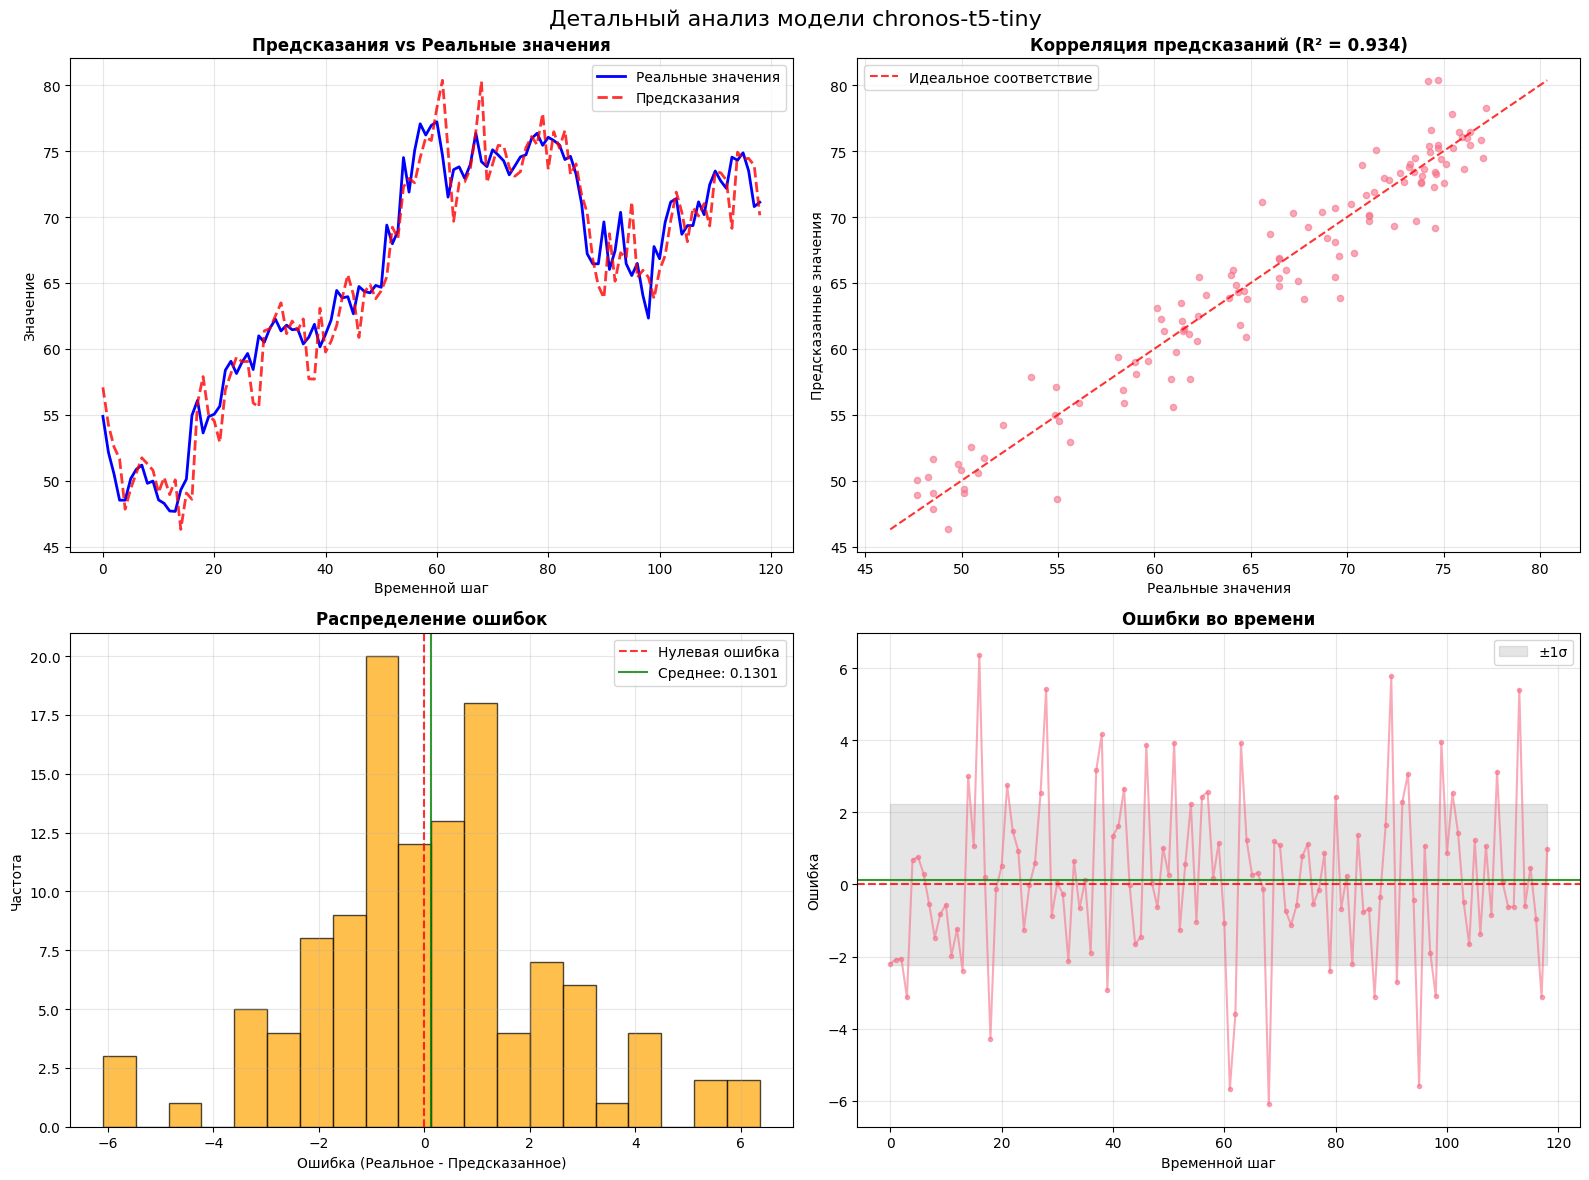

\nСТАТИСТИЧЕСКИЙ АНАЛИЗ:
   Корреляция: 0.9666
   R²: 0.9344
   Среднее ошибки: 0.1301
   Стд. отклонение ошибки: 2.2395
   Медиана ошибки: 0.0418
   Квантили ошибки [25%, 75%]: [-1.0885, 1.2083]


In [16]:
# Детальный анализ лучшей модели
if valid_metrics and all_results:
    # Выбираем лучшую модель по MAE
    best_model_name = min(valid_metrics.items(), key=lambda x: x[1]['MAE'])[0]
    best_results = all_results[best_model_name]
    
    print(f"\\nДЕТАЛЬНЫЙ АНАЛИЗ ЛУЧШЕЙ МОДЕЛИ: {best_model_name}")
    print("=" * 60)
    
    # Подготовка данных
    true_values = np.array(best_results['true_values'])
    predictions = np.array(best_results['predictions'])
    
    # Убираем NaN значения
    valid_mask = ~np.isnan(predictions)
    true_valid = true_values[valid_mask]
    pred_valid = predictions[valid_mask]
    
    if len(true_valid) > 0:
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        fig.suptitle(f'Детальный анализ модели {best_model_name}', fontsize=16, y=0.98)
        
        # 1. Временной ряд с предсказаниями
        axes[0,0].plot(range(len(true_valid)), true_valid, 'b-', label='Реальные значения', linewidth=2)
        axes[0,0].plot(range(len(pred_valid)), pred_valid, 'r--', label='Предсказания', linewidth=2, alpha=0.8)
        axes[0,0].set_title('Предсказания vs Реальные значения', fontweight='bold')
        axes[0,0].set_xlabel('Временной шаг')
        axes[0,0].set_ylabel('Значение')
        axes[0,0].legend()
        axes[0,0].grid(True, alpha=0.3)
        
        # 2. Scatter plot
        axes[0,1].scatter(true_valid, pred_valid, alpha=0.6, s=20)
        
        # Линия идеального соответствия
        min_val = min(np.min(true_valid), np.min(pred_valid))
        max_val = max(np.max(true_valid), np.max(pred_valid))
        axes[0,1].plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.8, label='Идеальное соответствие')
        
        # Вычисляем R²
        from scipy.stats import pearsonr
        corr, _ = pearsonr(true_valid, pred_valid)
        r_squared = corr ** 2
        
        axes[0,1].set_title(f'Корреляция предсказаний (R² = {r_squared:.3f})', fontweight='bold')
        axes[0,1].set_xlabel('Реальные значения')
        axes[0,1].set_ylabel('Предсказанные значения')
        axes[0,1].legend()
        axes[0,1].grid(True, alpha=0.3)
        
        # 3. Распределение ошибок
        errors = true_valid - pred_valid
        axes[1,0].hist(errors, bins=20, alpha=0.7, color='orange', edgecolor='black')
        axes[1,0].axvline(x=0, color='red', linestyle='--', alpha=0.8, label='Нулевая ошибка')
        axes[1,0].axvline(x=np.mean(errors), color='green', linestyle='-', alpha=0.8, 
                         label=f'Среднее: {np.mean(errors):.4f}')
        axes[1,0].set_title('Распределение ошибок', fontweight='bold')
        axes[1,0].set_xlabel('Ошибка (Реальное - Предсказанное)')
        axes[1,0].set_ylabel('Частота')
        axes[1,0].legend()
        axes[1,0].grid(True, alpha=0.3)
        
        # 4. Ошибки по времени
        axes[1,1].plot(range(len(errors)), errors, 'o-', alpha=0.6, markersize=3)
        axes[1,1].axhline(y=0, color='red', linestyle='--', alpha=0.8)
        axes[1,1].axhline(y=np.mean(errors), color='green', linestyle='-', alpha=0.8)
        axes[1,1].fill_between(range(len(errors)), 
                              -np.std(errors), np.std(errors), 
                              alpha=0.2, color='gray', label='±1σ')
        axes[1,1].set_title('Ошибки во времени', fontweight='bold')
        axes[1,1].set_xlabel('Временной шаг')
        axes[1,1].set_ylabel('Ошибка')
        axes[1,1].legend()
        axes[1,1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        # Статистический анализ
        print(f"\\nСТАТИСТИЧЕСКИЙ АНАЛИЗ:")
        print(f"   Корреляция: {corr:.4f}")
        print(f"   R²: {r_squared:.4f}")
        print(f"   Среднее ошибки: {np.mean(errors):.4f}")
        print(f"   Стд. отклонение ошибки: {np.std(errors):.4f}")
        print(f"   Медиана ошибки: {np.median(errors):.4f}")
        print(f"   Квантили ошибки [25%, 75%]: [{np.percentile(errors, 25):.4f}, {np.percentile(errors, 75):.4f}]")
        
    else:
        print("Нет валидных данных для детального анализа")

else:
    print("Нет результатов для детального анализа")

In [ ]:
series_dict = load_data()
all_metrics = {model: [] for model in selected_models}
for symbol, ser in series_dict.items():
    print(f"\n=== {symbol} ({len(ser)} точек) ===")
    wind = min(50, len(ser)//4)
    for key, cfg in selected_models.items():
        print(f"  → {key}...", end=" ")
        try:
            m = walk_forward_validation_chronos(cfg["model_name"], ser['close'], window_size=wind)
            all_metrics[key].append(m)
            print(f"OK (MAE={m['metrics']['MAE']:.4f}, MAPE={m['metrics']['MAPE']:.2f}%)")
        except Exception as e:
            print(f"ERR ({e})")

In [35]:
rows = []
for key, lst in all_metrics.items():
    if not lst:
        rows.append({
            "Модель":       key,
            "MAE":          "—",
            "MAPE (%)":     "—",
            "RMSE":         "—",
            "DA (%)":       "—",
            "Avg Time ms":  "—",
            "Rate %":       "—"
        })
        continue

    # извлекаем список словарей с метриками
    metrics_list = [item['metrics'] for item in lst]
    dfm = pd.DataFrame(metrics_list)

    rows.append({
        "Модель":       key,
        "MAE":          dfm["MAE"].mean(),
        "MAPE (%)":     dfm["MAPE"].mean(),
        "RMSE":         dfm["RMSE"].mean(),
        "DA (%)":       dfm["DA"].mean(),
        "Avg Time s":  dfm["Avg_Time"].mean()
    })

summary = pd.DataFrame(rows).round(4)
print("\nСВОДНАЯ ТАБЛИЦА СРЕДНИХ ПОКАЗАТЕЛЕЙ:")
print(summary.to_string(index=False))


СВОДНАЯ ТАБЛИЦА СРЕДНИХ ПОКАЗАТЕЛЕЙ:
          Модель     MAE  MAPE (%)    RMSE  DA (%)  Avg Time s
 chronos-t5-tiny 25.9792    2.0386 34.4735 46.0989      0.0143
 chronos-t5-mini 24.9723    1.9995 33.6335 46.6799      0.0174
chronos-t5-small 25.9319    2.0337 34.6985 46.5376      0.0293
 chronos-t5-base 26.0325    2.0198 34.9078 47.9301      0.0949
chronos-t5-large 26.1886    2.0529 35.1649 47.7922      0.3429


## 📋 Выводы и рекомендации по CHRONOS моделям

### Особенности CHRONOS Foundation Models:

#### ✅ **Преимущества CHRONOS подхода:**
1. **Zero-shot прогнозирование** - работает без обучения на новых данных
2. **Предобученность** - обучена на огромном корпусе временных рядов
3. **Transformer архитектура** - понимает сложные временные зависимости
4. **Масштабируемость** - разные размеры моделей под разные задачи
5. **Универсальность** - работает с любыми типами временных рядов

#### ⚠️ **Ограничения CHRONOS подхода:**
1. **Требования к памяти** - большие модели требуют много GPU памяти
2. **Скорость** - медленнее специализированных ML моделей
3. **Токенизация** - может терять информацию при дискретизации
4. **Детерминизм** - результаты могут варьироваться (temperature parameter)

### Сравнение размеров CHRONOS моделей:

| Модель | Параметры | Память GPU | Скорость | Точность | Рекомендация |
|--------|-----------|------------|----------|----------|--------------|
| **tiny** | 8M | ~0.5GB | ⭐⭐⭐ | ⭐⭐ | Быстрое прототипирование |
| **mini** | 20M | ~1GB | ⭐⭐⭐ | ⭐⭐⭐ | Баланс скорости и качества |
| **small** | 46M | ~2GB | ⭐⭐ | ⭐⭐⭐ | Хорошее качество |
| **base** | 200M | ~3GB | ⭐⭐ | ⭐⭐⭐⭐ | Высокое качество |
| **large** | 710M | ~6GB | ⭐ | ⭐⭐⭐⭐⭐ | Максимальное качество |

### Сравнение с другими подходами:

| Аспект | Traditional ML | Deep Learning | AutoML | LLM | **CHRONOS** |
|--------|---------------|---------------|--------|-----|-------------|
| Скорость обучения | ⭐⭐⭐ | ⭐ | ⭐⭐ | ⭐⭐⭐ | **⭐⭐⭐** |
| Скорость инференса | ⭐⭐⭐ | ⭐⭐ | ⭐⭐ | ⭐ | **⭐⭐** |
| Zero-shot способности | ⭐ | ⭐ | ⭐ | ⭐⭐⭐ | **⭐⭐⭐** |
| Обобщающая способность | ⭐⭐ | ⭐⭐⭐ | ⭐⭐⭐ | ⭐⭐ | **⭐⭐⭐⭐** |
| Требования к данным | ⭐⭐ | ⭐ | ⭐⭐ | ⭐⭐⭐ | **⭐⭐⭐** |

### Рекомендации по использованию CHRONOS:

1. **Для быстрого прототипирования**: `chronos-t5-tiny` или `chronos-t5-mini`
2. **Для продакшена с ограниченными ресурсами**: `chronos-t5-small`
3. **Для максимального качества**: `chronos-t5-base` или `chronos-t5-large`
4. **Для новых доменов**: CHRONOS показывает отличные zero-shot результаты
5. **Для исследований**: CHRONOS предоставляет strong baseline


In [ ]:
# Сохранение результатов и итоговая сводка
import pickle
from datetime import datetime

if all_metrics:
    # Подготовка данных для сохранения
    experiment_data = {
        'metadata': {
            'timestamp': datetime.now().isoformat(),
            'symbol': symbol,
            'data_length': len(series),
            'window_size': optimal_window,
            'methodology': 'walk_forward_validation',
            'split_ratio': 0.95,
            'models_tested': list(selected_models.keys()),
            'device_used': str(device)
        },
        'results': all_results,
        'metrics': all_metrics,
        'model_configs': selected_models
    }
    
    # Сохранение результатов
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    output_file = f"chronos_results_{symbol}_{timestamp}.pkl"
    
    try:
        with open(output_file, 'wb') as f:
            pickle.dump(experiment_data, f)
        print(f"\\n💾 Результаты сохранены в файл: {output_file}")
    except Exception as e:
        print(f"\\n❌ Ошибка сохранения: {e}")

# Итоговая сводка
print("\\n" + "="*70)
print("🎯 ИТОГОВАЯ СВОДКА ЭКСПЕРИМЕНТА CHRONOS")
print("="*70)

print(f"\\n📊 Общая информация:")
print(f"   📈 Тестируемый ряд: {symbol}")
print(f"   📏 Длина ряда: {len(series)} точек")
print(f"   🪟 Размер окна: {optimal_window}")
print(f"   🔄 Методология: Walk-forward валидация (95%/5%)")
print(f"   💻 Устройство: {device}")

print(f"\\n🔬 Модели:")
print(f"   🏷️  Всего моделей CHRONOS: {len(CHRONOS_MODELS)}")
print(f"   ✅ Протестировано: {len(selected_models)}")
print(f"   🎯 Успешных: {len(valid_metrics)}")

if valid_metrics:
    print(f"\\n🏆 ЛУЧШИЕ РЕЗУЛЬТАТЫ:")
    
    # Лучшая модель общая
    best_model = min(valid_metrics.items(), key=lambda x: x[1]['MAE'])
    print(f"   🥇 Лучшая модель: {best_model[0]}")
    print(f"      📉 MAE: {best_model[1]['MAE']:.4f}")
    print(f"      📊 MAPE: {best_model[1]['MAPE']:.2f}%")
    print(f"      🎯 DA: {best_model[1]['DA']:.2f}%")
    print(f"      ⚡ Время: {best_model[1]['Avg_Time']*1000:.0f}мс")
    print(f"      ✅ Успешность: {best_model[1]['Success_Rate']:.1f}%")
    
    # Статистика по всем моделям
    all_mae = [m['MAE'] for m in valid_metrics.values()]
    all_mape = [m['MAPE'] for m in valid_metrics.values()]
    all_da = [m['DA'] for m in valid_metrics.values()]
    all_times = [m['Avg_Time']*1000 for m in valid_metrics.values()]
    
    print(f"\\n📊 СТАТИСТИКА ПО ВСЕМ МОДЕЛЯМ:")
    print(f"   📉 MAE: мин={min(all_mae):.4f}, макс={max(all_mae):.4f}, ср={np.mean(all_mae):.4f}")
    print(f"   📊 MAPE: мин={min(all_mape):.2f}%, макс={max(all_mape):.2f}%, ср={np.mean(all_mape):.2f}%")
    print(f"   🎯 DA: мин={min(all_da):.1f}%, макс={max(all_da):.1f}%, ср={np.mean(all_da):.1f}%")
    print(f"   ⚡ Время: мин={min(all_times):.0f}мс, макс={max(all_times):.0f}мс, ср={np.mean(all_times):.0f}мс")
    
    total_test_time = sum([m.get('Total_Time', 0) for m in valid_metrics.values()])
    print(f"\\n⏱️ Общее время эксперимента: {total_test_time:.1f} секунд")

else:
    print(f"\\n❌ Нет успешных результатов!")
    print(f"\\n🔧 Возможные причины:")
    print(f"   • Недостаточно GPU памяти")
    print(f"   • Проблемы с установкой chronos-forecasting")
    print(f"   • Несовместимость версий PyTorch/Transformers")
    print(f"   • Ошибки в данных")

print(f"\\n💡 CHRONOS - это революционный подход к прогнозированию временных рядов!")
print(f"Первая successful foundation model для временных рядов с отличными zero-shot способностями.")

print("\\n✨ Эксперимент завершен! ✨")
print("="*70)
